# Wider SYREN: Symbolic Approximations for Cosmology

This notebook demonstrates the symbolic regression-based approximations developed in the `wider_syren` module. These functions provide fast, accurate approximations to various cosmological quantities that would otherwise require expensive numerical computations.

Compared to the other parts of this repository, we use wider priors here (hence the name) and restrict ourselves to ΛCDM. These priors are

| Parameter      | Description                          | Min Value | Max Value |
|--------------|----------------------------------|-----------|-----------|
| $\Omega_m$  | Matter density parameter        | 0.1      | 0.5      |
| $\Omega_b$  | Baryon density parameter        | 0.03     | 0.07     |
| $h$    | Hubble constant ($H_0 = 100 h {\rm \ km/s/Mpc}$)       | 0.5       | 0.9        |
| $n_s$      | Scalar spectral index           | 0.8      | 1.2      |
| $\sigma_8$  | Matter fluctuation amplitude    | 0.6      | 1.0      |
| $z$  | Redshift    | 0.0      | 3.0      |
| $k$  | Wavenumber ($h \, {\rm Mpc}^{-1}$)    | $10^{-4}$      | $10^2$      |

The symbolic expressions were derived using symbolic regression techniques and are designed to match the outputs of standard cosmological codes like CAMB while being orders of magnitude faster to evaluate.

If you use any of the approximations or functions found in this notebook, please cite Bartlett & Pandey 2025 (arXiv:2510.18749)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.stats.qmc
import camb

import symbolic_pofk.wider_syren.background as background
import symbolic_pofk.wider_syren.linear as linear
import symbolic_pofk.wider_syren.halofit as halofit

# Set plotting style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Background Cosmology: Hypergeometric Functions and Comoving Distance

### 1.1 Hypergeometric Function Approximation

The Gaussian hypergeometric function ${}_2F_1(a,b,c;x)$ appears frequently in cosmological calculations for ΛCDM universes. Computing it numerically can be expensive, so we use a symbolic approximation.

**Ground Truth**: The exact hypergeometric function is computed using `scipy.special.hyp2f1(2/3, 1, 7/6, x)`.

**Our Approximation**: `symbolic_2f1_comoving(x)` provides a fast analytical approximation fitted over the relevant cosmological parameter range.

Maximum fractional error: 0.0015%
RMS fractional error: 0.0011%


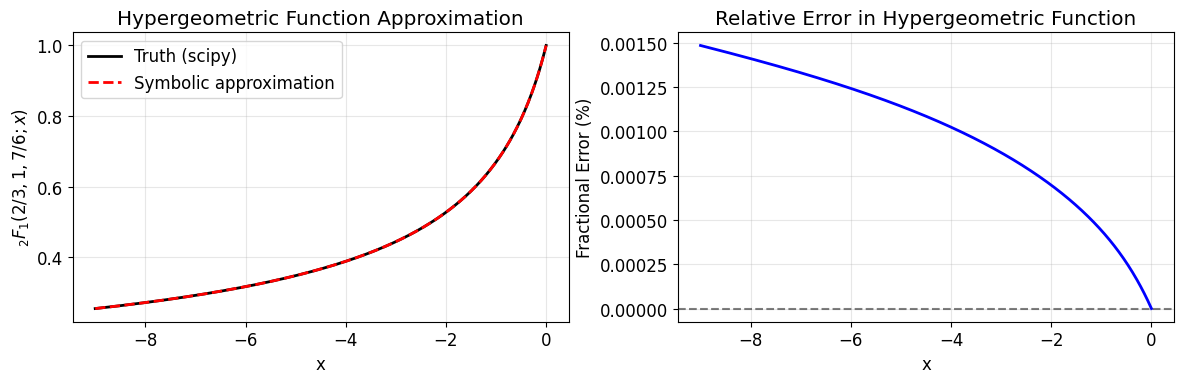

In [2]:
# Define parameter ranges based on cosmological priors
Om_min, Om_max = 0.1, 0.5
z_min, z_max = 0, 10
a_min = 1 / (1 + z_max)
a_max = 1 / (1 + z_min)
x_min = (1 - 1 / Om_min) * a_max ** 3
x_max = (1 - 1 / Om_max) * a_min ** 3

# Sample x values
x_samples = np.linspace(x_min, x_max, 500)

# Compute truth and prediction
hyp2f1_true = scipy.special.hyp2f1(2/3, 1, 7/6, x_samples)
hyp2f1_pred = background.symbolic_2f1_comoving(x_samples)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Upper panel: Direct comparison
axes[0].plot(x_samples, hyp2f1_true, 'k-', label='Truth (scipy)', linewidth=2)
axes[0].plot(x_samples, hyp2f1_pred, 'r--', label='Symbolic approximation', linewidth=2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('$_2F_1(2/3, 1, 7/6; x)$')
axes[0].set_title('Hypergeometric Function Approximation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Lower panel: Fractional error
fractional_error = (hyp2f1_pred - hyp2f1_true) / hyp2f1_true
axes[1].plot(x_samples, fractional_error * 100, 'b-', linewidth=2)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('Fractional Error (%)')
axes[1].set_title('Relative Error in Hypergeometric Function')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

print(f"Maximum fractional error: {np.max(np.abs(fractional_error)) * 100:.4f}%")
print(f"RMS fractional error: {np.sqrt(np.mean(fractional_error**2)) * 100:.4f}%")

### 1.2 Radial Comoving Distance

The radial comoving distance is fundamental for converting between redshift and physical separation:

$$\chi(z) = R_H \int_0^z \frac{dz^\prime}{E(z^\prime)}$$

where $E(z) = H(z) / H_0$ for Hubble rate $H(z)$.

For ΛCDM, this integral involves the hypergeometric function ${}_2F_1$. 

**Ground Truth**: Exact analytical expression using `scipy.special.hyp2f1`.

**Our Approximation**: `symbolic_radial_comoving(Om, z)` uses our symbolic hypergeometric approximation.

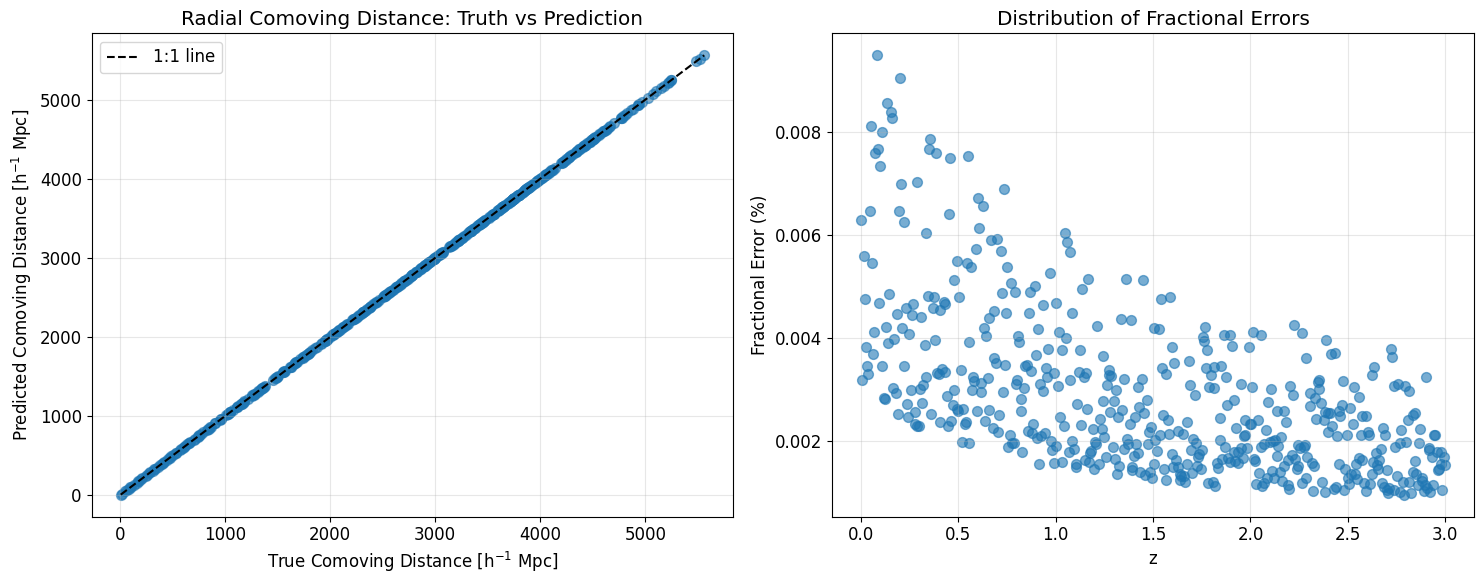

Maximum fractional error: 0.0095%
RMS fractional error: 0.0033%


In [3]:
# Sample cosmological parameters using Latin Hypercube Sampling
all_prior = [[0.1, 0.5], [0, 3]]  # Om, z
npoints = 500
seed = 1234
d = len(all_prior)

lh_sampler = scipy.stats.qmc.LatinHypercube(d, seed=seed)
samples = lh_sampler.random(npoints)
for i in range(d):
    samples[:, i] = all_prior[i][0] + (all_prior[i][1] - all_prior[i][0]) * samples[:, i]

Om = samples[:, 0]
z = samples[:, 1]

# Compute ground truth
a = 1 / (1 + z)
x = (Om - 1) / Om * a ** 3
lower = a**2 * np.sqrt(Om * a**(-3) + 1 - Om) * scipy.special.hyp2f1(2/3, 1, 7/6, x)
x_upper = (Om - 1) / Om
upper = scipy.special.hyp2f1(2/3, 1, 7/6, x_upper)
rh = 2997.92458  # h^{-1} Mpc
chi_true = 2 * rh / Om * (upper - lower)

# Compute symbolic prediction
chi_pred = background.symbolic_radial_comoving(Om, z)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: 1-to-1 comparison
axes[0].scatter(chi_true, chi_pred, alpha=0.6, s=50)
min_val = min(chi_true.min(), chi_pred.min())
max_val = max(chi_true.max(), chi_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 line')
axes[0].set_xlabel('True Comoving Distance [h$^{-1}$ Mpc]')
axes[0].set_ylabel('Predicted Comoving Distance [h$^{-1}$ Mpc]')
axes[0].set_title('Radial Comoving Distance: Truth vs Prediction')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right panel: Fractional error distribution
fractional_error = (chi_pred - chi_true) / chi_true
m = np.argsort(z)
axes[1].scatter(z[m], fractional_error[m] * 100, alpha=0.6, s=50)
axes[1].set_xlabel('z')
axes[1].set_ylabel('Fractional Error (%)')
axes[1].set_title('Distribution of Fractional Errors')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum fractional error: {np.max(np.abs(fractional_error)) * 100:.4f}%")
print(f"RMS fractional error: {np.sqrt(np.mean(fractional_error**2)) * 100:.4f}%")

## 2. Linear Growth: Growth Factor and Growth Rate

### 2.1 Linear Growth Factor D(z)

The linear growth factor describes how density perturbations grow with time in a ΛCDM universe:

$$D(a) = a \cdot {}_2F_1(1/3, 1, 11/6; x)$$

where $x = (\Omega_m - 1) / \Omega_m \cdot a^3$.

**Ground Truth**: Exact analytical expression using `scipy.special.hyp2f1`.

**Our Approximation**: `symbolic_D(Om, z)` uses a fitted symbolic expression.

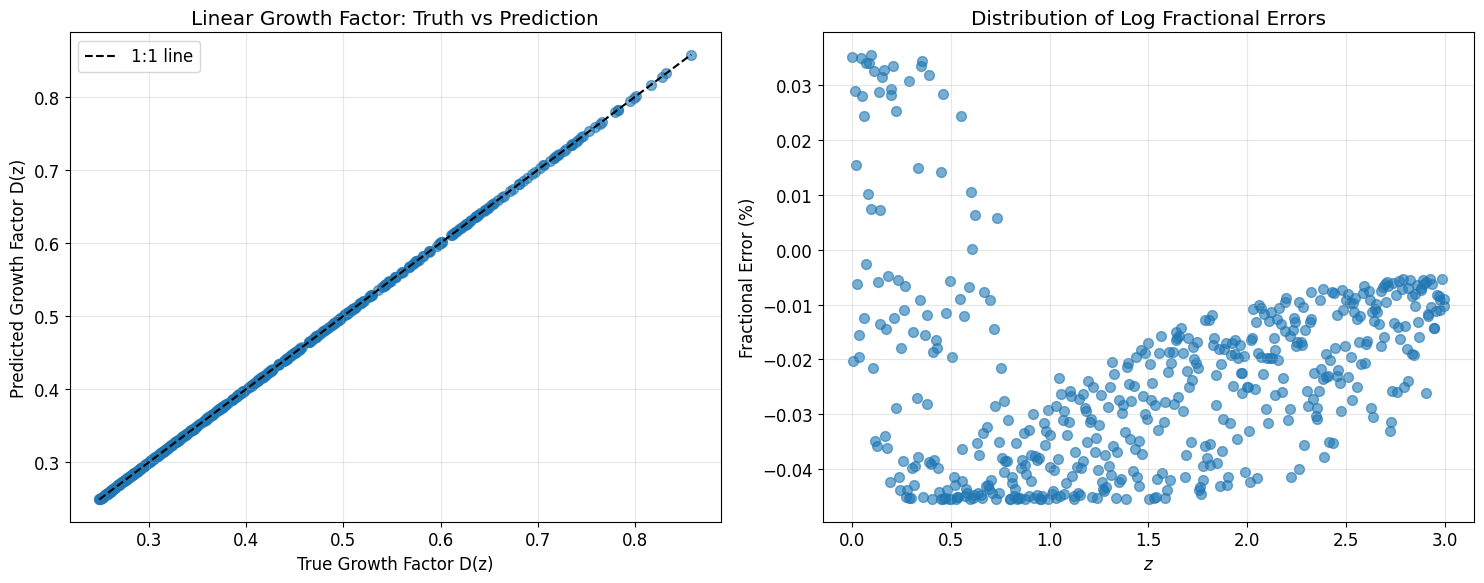

Maximum log fractional error: 0.0456%
RMS log fractional error: 0.0294%


In [4]:
# Sample parameters
all_prior = [[0.1, 0.5], [0, 3]]  # Om, z
npoints = 500
lh_sampler = scipy.stats.qmc.LatinHypercube(d, seed=seed)
samples = lh_sampler.random(npoints)
for i in range(d):
    samples[:, i] = all_prior[i][0] + (all_prior[i][1] - all_prior[i][0]) * samples[:, i]

Om = samples[:, 0]
z = samples[:, 1]

# Compute ground truth
a = 1 / (1 + z)
x = (Om - 1) / Om * a ** 3
D_true = a * scipy.special.hyp2f1(1/3, 1, 11/6, x)

# Compute symbolic prediction
D_pred = linear.symbolic_D(Om, z)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: 1-to-1 comparison
axes[0].scatter(D_true, D_pred, alpha=0.6, s=50)
min_val = min(D_true.min(), D_pred.min())
max_val = max(D_true.max(), D_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 line')
axes[0].set_xlabel('True Growth Factor D(z)')
axes[0].set_ylabel('Predicted Growth Factor D(z)')
axes[0].set_title('Linear Growth Factor: Truth vs Prediction')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right panel: Log-space fractional error
fractional_error = (D_pred - D_true) / D_true
m = np.argsort(z)
axes[1].scatter(z[m], fractional_error[m] * 100, alpha=0.6, s=50)
axes[1].set_xlabel('$z$')
axes[1].set_ylabel('Fractional Error (%)')
axes[1].set_title('Distribution of Log Fractional Errors')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum log fractional error: {np.max(np.abs(fractional_error)) * 100:.4f}%")
print(f"RMS log fractional error: {np.sqrt(np.mean(fractional_error**2)) * 100:.4f}%")

### 2.2 Linear Growth Rate f(z)

The growth rate $f = d\ln D / d\ln a$ describes how fast structures grow. It can be expressed analytically in terms of hypergeometric functions:

$$f(z) = 1 + \frac{6 a^3 (\Omega_m - 1)}{11 \Omega_m} \frac{{}_2F_1(4/3, 2, 17/6; x)}{{}_2F_1(1/3, 1, 11/6; x)}$$

**Ground Truth**: Exact analytical expression using `scipy.special.hyp2f1`.

**Our Approximation**: `symbolic_f(Om, z)` provides a fast symbolic approximation.

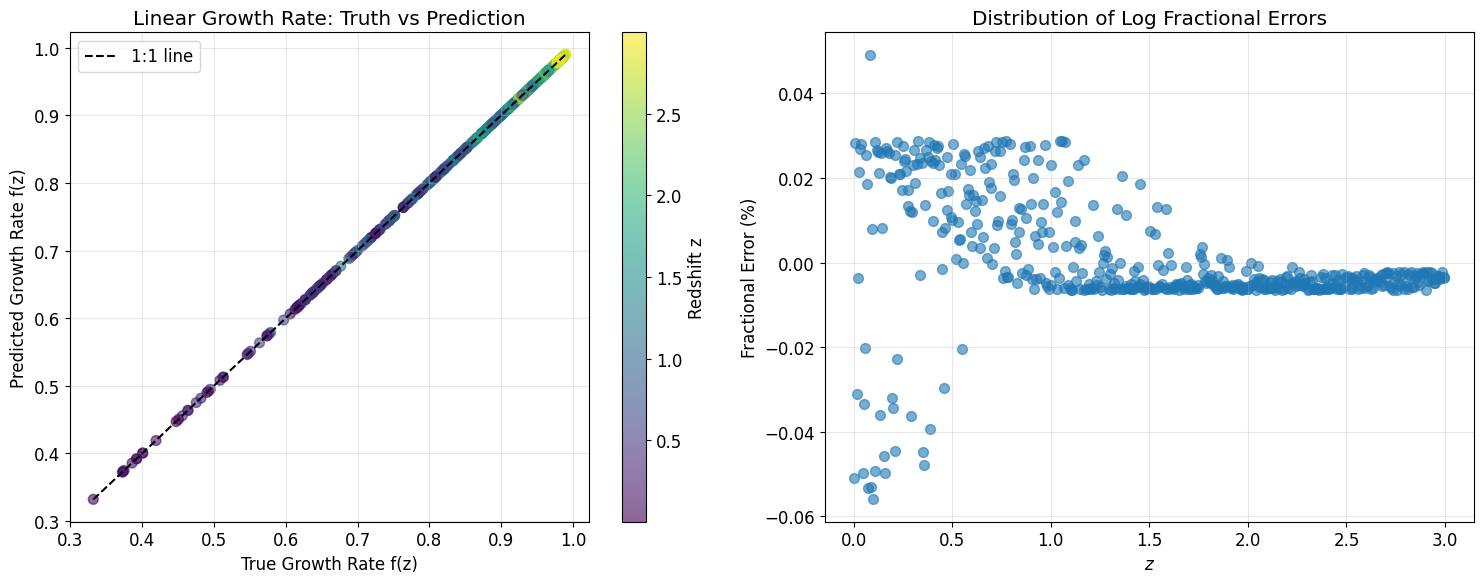

Maximum log fractional error: 0.0560%
RMS log fractional error: 0.0145%


In [5]:
# Use same samples as before
# Compute ground truth
f_true = (1 + 6 * a ** 3 * (Om - 1) / (11 * Om) * 
          scipy.special.hyp2f1(4/3, 2, 17/6, x) /
          scipy.special.hyp2f1(1/3, 1, 11/6, x))

# Compute symbolic prediction
f_pred = linear.symbolic_f(Om, z)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: 1-to-1 comparison
axes[0].scatter(f_true, f_pred, alpha=0.6, s=50, c=z, cmap='viridis')
min_val = min(f_true.min(), f_pred.min())
max_val = max(f_true.max(), f_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 line')
axes[0].set_xlabel('True Growth Rate f(z)')
axes[0].set_ylabel('Predicted Growth Rate f(z)')
axes[0].set_title('Linear Growth Rate: Truth vs Prediction')
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Redshift z')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right panel: Log-space fractional error
fractional_error = (f_pred - f_true) / f_true
m = np.argsort(z)
axes[1].scatter(z[m], fractional_error[m] * 100, alpha=0.6, s=50)
axes[1].set_ylabel('Fractional Error (%)')
axes[1].set_xlabel('$z$')
axes[1].set_title('Distribution of Log Fractional Errors')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum log fractional error: {np.max(np.abs(fractional_error)) * 100:.4f}%")
print(f"RMS log fractional error: {np.sqrt(np.mean(fractional_error**2)) * 100:.4f}%")

## 3. Normalization: σ₈ and Aₛ

### 3.1 Conversion between σ₈ and Aₛ

The amplitude of matter fluctuations can be specified either by:
- **σ₈**: RMS density fluctuation in spheres of radius 8 h⁻¹ Mpc
- **Aₛ**: Amplitude of the primordial power spectrum

These are related through the linear transfer function and growth factor.

**Ground Truth**: CAMB calculation of σ₈ from Aₛ.

**Our Approximation**: `symbolic_sigma8(Om, Ob, h, ns, As)` and the inverse `symbolic_As(Om, Ob, h, ns, sigma8)`.

In [6]:
# Define Planck-like cosmology
As = 2.105e-9
h = 0.6766
Om = 0.3111
Ob = 0.02242 / h ** 2
ns = 0.9665
tau = 0.0561

# Compute σ₈ using symbolic approximation
sigma8_symbolic = linear.symbolic_sigma8(Om, Ob, h, ns, As)

# Check inversion: As -> σ₈ -> As
As_inverse = linear.symbolic_As(Om, Ob, h, ns, sigma8_symbolic)

print(f"Original Aₛ: {As:.6e}")
print(f"Symbolic σ₈: {sigma8_symbolic:.6f}")
print(f"Inverted Aₛ: {As_inverse:.6e}")
print(f"Inversion error: {np.abs(As - As_inverse) / As * 100:.6f}%\n")

# Compare with CAMB
pars = camb.CAMBparams()
pars.set_cosmology(H0=h*100,
                   ombh2=Ob * h ** 2,
                   omch2=(Om - Ob) * h ** 2,
                   mnu=0.0,
                   omk=0,
                   tau=tau)
pars.InitPower.set_params(As=As, ns=ns, r=0)
pars.set_matter_power(redshifts=[0.], kmax=9)
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
sigma8_camb = results.get_sigma8()[0]

print(f"CAMB σ₈: {sigma8_camb:.6f}")
print(f"Symbolic σ₈: {sigma8_symbolic:.6f}")
print(f"Difference: {np.abs(sigma8_symbolic - sigma8_camb) / sigma8_camb * 100:.4f}%")

Original Aₛ: 2.105000e-09
Symbolic σ₈: 0.824623
Inverted Aₛ: 2.105000e-09
Inversion error: 0.000000%

CAMB σ₈: 0.824760
Symbolic σ₈: 0.824623
Difference: 0.0166%


## 4. Linear Matter Power Spectrum P(k)

The linear matter power spectrum describes the distribution of matter fluctuations as a function of scale k.

**Ground Truth**: CAMB calculation using full Boltzmann solver.

**Our Approximation**: `symbolic_pklin(Om, Ob, h, ns, sigma8, z, k)` builds on the Eisenstein-Hu approximation with symbolic corrections to match CAMB for improved accuracy.

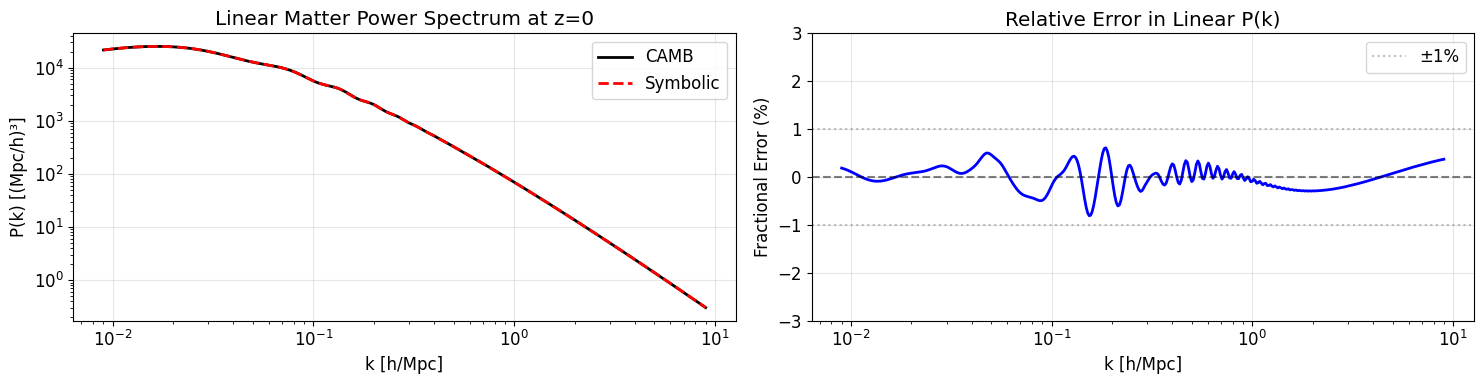

Maximum fractional error: 0.8092%
RMS fractional error: 0.2465%


In [7]:
# Define k range
kmin = 9e-3
kmax = 9
nk = 400
k = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Get CAMB P(k)
pars = camb.CAMBparams()
pars.set_cosmology(H0=h*100,
                   ombh2=Ob * h ** 2,
                   omch2=(Om - Ob) * h ** 2,
                   mnu=0.0,
                   omk=0,
                   tau=tau)
pars.InitPower.set_params(As=As, ns=ns, r=0)
pars.set_matter_power(redshifts=[0.], kmax=9)
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
_, _, pk_camb = results.get_matter_power_spectrum(
    minkh=k.min(), maxkh=k.max(), npoints=len(k))
pk_camb = pk_camb[0, :]

# Get symbolic P(k)
pk_symbolic = linear.symbolic_pklin(Om, Ob, h, ns, sigma8_symbolic, 0.0, k)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Upper panel: P(k) comparison
axes[0].loglog(k, pk_camb, 'k-', label='CAMB', linewidth=2)
axes[0].loglog(k, pk_symbolic, 'r--', label='Symbolic', linewidth=2)
axes[0].set_xlabel('k [h/Mpc]')
axes[0].set_ylabel('P(k) [(Mpc/h)³]')
axes[0].set_title('Linear Matter Power Spectrum at z=0')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Lower panel: Fractional error
fractional_error = (pk_symbolic - pk_camb) / pk_camb
axes[1].semilogx(k, fractional_error * 100, 'b-', linewidth=2)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1].axhline(y=1, color='gray', linestyle=':', alpha=0.5, label='±1%')
axes[1].axhline(y=-1, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('k [h/Mpc]')
axes[1].set_ylabel('Fractional Error (%)')
axes[1].set_title('Relative Error in Linear P(k)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-3, 3)

plt.tight_layout()
plt.show()

print(f"Maximum fractional error: {np.max(np.abs(fractional_error)) * 100:.4f}%")
print(f"RMS fractional error: {np.sqrt(np.mean(fractional_error**2)) * 100:.4f}%")

## 5. Nonlinear Power Spectrum with HALOFIT

On small scales (high $k$), gravitational collapse becomes nonlinear. The HALOFIT model provides a fitting formula for the nonlinear power spectrum.

HALOFIT requires three quantities:
- **$k_\sigma$**: The nonlinear wavenumber where $\sigma(k_\sigma^{-1})=1$
- **$n_{\rm eff}$**: The effective spectral index at $k_\sigma$
- **$C$**: The effective curvature at $k_\sigma$

**Ground Truth**: CAMB with HALOFIT (Takahashi et al. 2012 version).

**Our Approximation**: Symbolic approximations for $k_\sigma$, $n_{\rm eff}$, and $C$, combined with the standard HALOFIT formula.

Note: redshifts have been re-sorted (earliest first)

z = 0.0:
  kσ (symbolic): 0.3523 h/Mpc
  neff (symbolic): -1.7348
  C (symbolic): 0.3431
  Max fractional error: 1.6837%
  RMS fractional error: 0.8676%

z = 1.0:
  kσ (symbolic): 0.8550 h/Mpc
  neff (symbolic): -1.9926
  C (symbolic): 0.2529
  Max fractional error: 0.8258%
  RMS fractional error: 0.2408%

z = 2.0:
  kσ (symbolic): 1.9405 h/Mpc
  neff (symbolic): -2.1710
  C (symbolic): 0.1896
  Max fractional error: 0.9303%
  RMS fractional error: 0.2997%


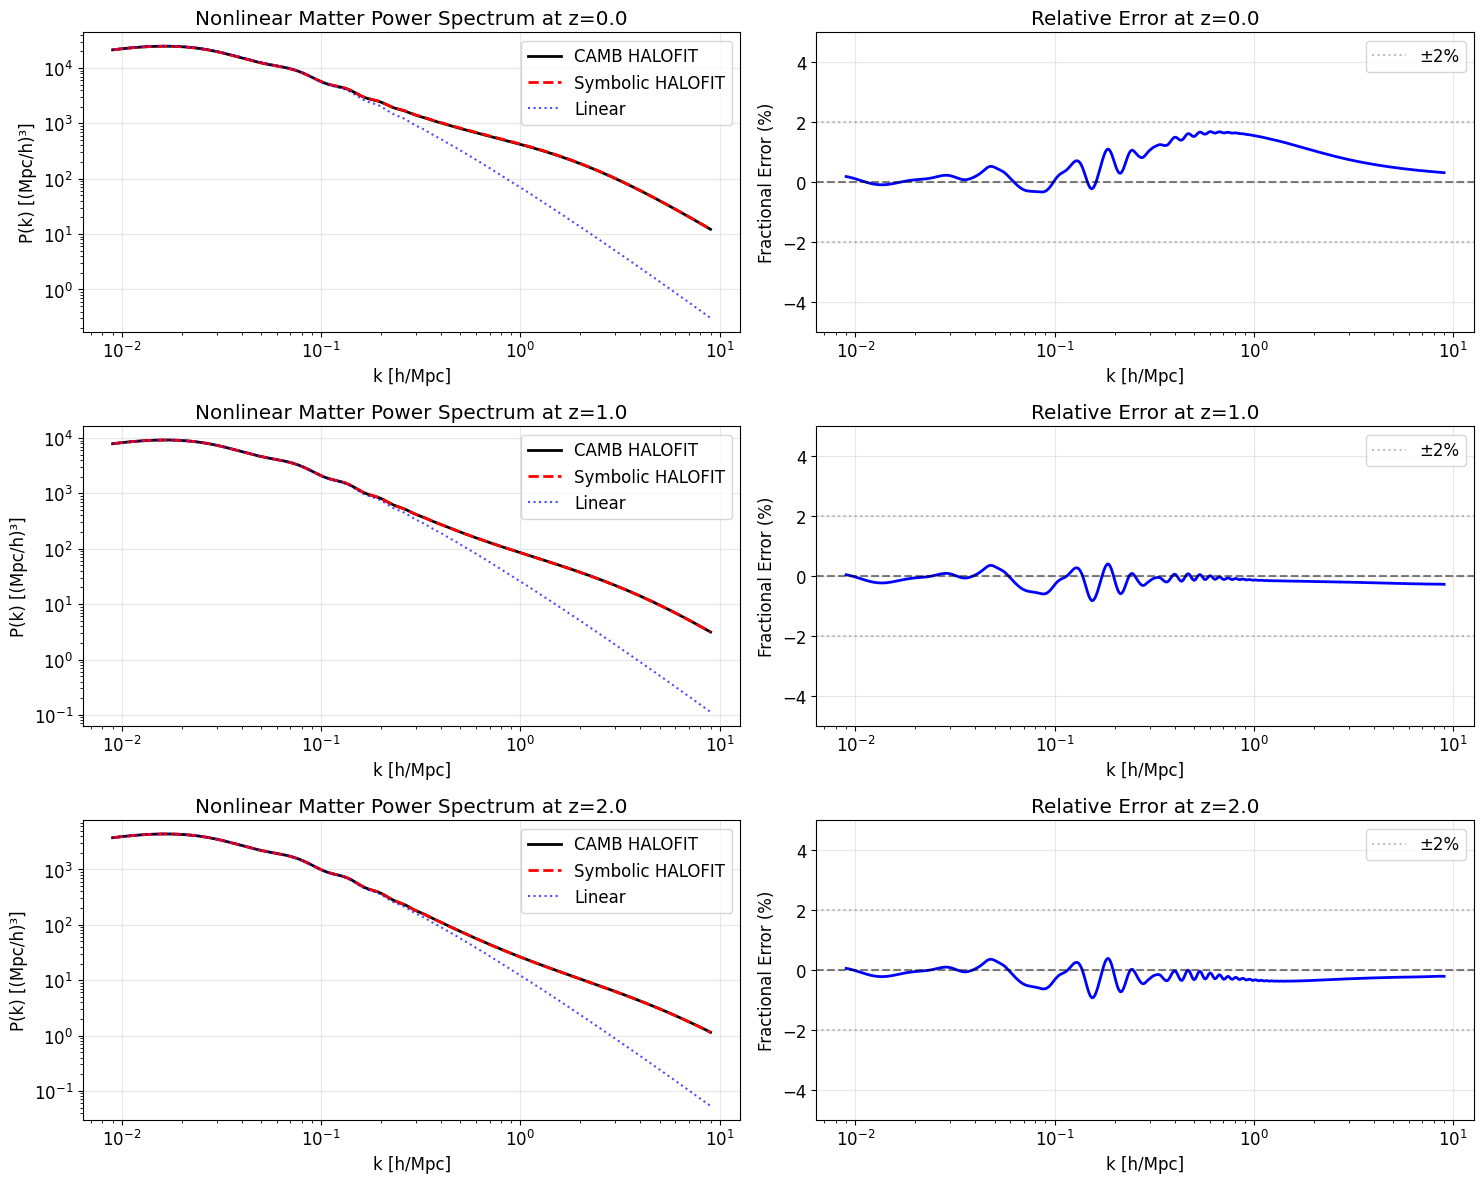

In [8]:
# Test at multiple redshifts
all_z = [0.0, 1.0, 2.0]

# Get CAMB nonlinear P(k)
pars = camb.CAMBparams()
pars.set_cosmology(H0=h*100,
                   ombh2=Ob * h ** 2,
                   omch2=(Om - Ob) * h ** 2,
                   mnu=0.0,
                   omk=0,
                   tau=tau)
pars.InitPower.set_params(As=As, ns=ns, r=0)
pars.set_matter_power(redshifts=all_z, kmax=9)
pars.NonLinear = camb.model.NonLinear_both
pars.NonLinearModel.set_params(halofit_version='takahashi')
results = camb.get_results(pars)
_, _, pk_camb_nl = results.get_matter_power_spectrum(
    minkh=k.min(), maxkh=k.max(), npoints=len(k))

# Create subplots for each redshift
fig, axes = plt.subplots(len(all_z), 2, figsize=(15, 4*len(all_z)))

for i, z in enumerate(all_z):
    # Compute symbolic nonlinear P(k)
    pk_lin = linear.symbolic_pklin(Om, Ob, h, ns, sigma8_symbolic, z, k)
    ksigma = halofit.symbolic_ksigma(Om, Ob, h, ns, sigma8_symbolic, z)
    neff = halofit.symbolic_neff(Om, Ob, h, ns, sigma8_symbolic, z)
    C = halofit.symbolic_C(Om, Ob, h, ns, sigma8_symbolic, z)
    pk_symbolic_nl = halofit.apply_halofit(k, pk_lin, Om, Ob, h, ns, sigma8_symbolic, z, 
                                           ksigma, neff, C)
    
    # Left panel: P(k) comparison
    axes[i, 0].loglog(k, pk_camb_nl[i], 'k-', label='CAMB HALOFIT', linewidth=2)
    axes[i, 0].loglog(k, pk_symbolic_nl, 'r--', label='Symbolic HALOFIT', linewidth=2)
    axes[i, 0].loglog(k, pk_lin, 'b:', label='Linear', linewidth=1.5, alpha=0.7)
    axes[i, 0].set_xlabel('k [h/Mpc]')
    axes[i, 0].set_ylabel('P(k) [(Mpc/h)³]')
    axes[i, 0].set_title(f'Nonlinear Matter Power Spectrum at z={z}')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Right panel: Fractional error
    fractional_error = (pk_symbolic_nl - pk_camb_nl[i]) / pk_camb_nl[i]
    axes[i, 1].semilogx(k, fractional_error * 100, 'b-', linewidth=2)
    axes[i, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[i, 1].axhline(y=2, color='gray', linestyle=':', alpha=0.5, label='±2%')
    axes[i, 1].axhline(y=-2, color='gray', linestyle=':', alpha=0.5)
    axes[i, 1].set_xlabel('k [h/Mpc]')
    axes[i, 1].set_ylabel('Fractional Error (%)')
    axes[i, 1].set_title(f'Relative Error at z={z}')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].set_ylim(-5, 5)
    
    print(f"\nz = {z}:")
    print(f"  kσ (symbolic): {ksigma:.4f} h/Mpc")
    print(f"  neff (symbolic): {neff:.4f}")
    print(f"  C (symbolic): {C:.4f}")
    print(f"  Max fractional error: {np.max(np.abs(fractional_error)) * 100:.4f}%")
    print(f"  RMS fractional error: {np.sqrt(np.mean(fractional_error**2)) * 100:.4f}%")

plt.tight_layout()
plt.show()

## 6. Visualization: Boost Factor $P_{\rm nl}/P_{\rm lin}$

The nonlinear boost shows how much the power spectrum is enhanced by nonlinear gravitational collapse compared to linear theory.

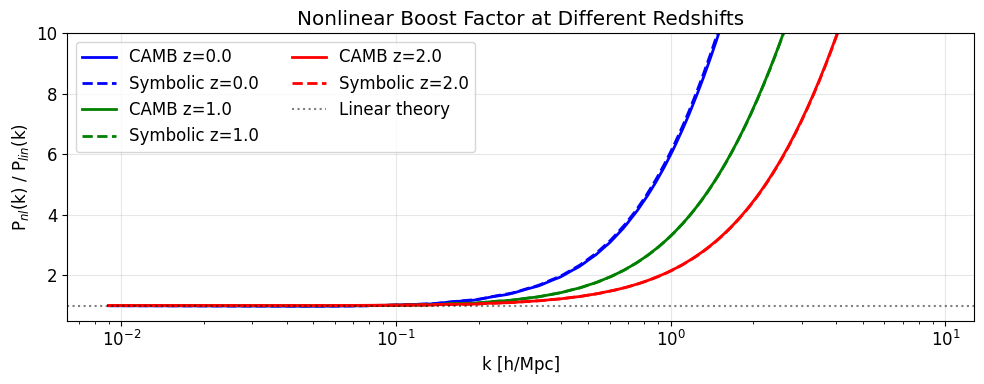

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

colors = ['blue', 'green', 'red']

for i, z in enumerate(all_z):
    # Compute boost factors
    pk_lin = linear.symbolic_pklin(Om, Ob, h, ns, sigma8_symbolic, z, k)
    ksigma = halofit.symbolic_ksigma(Om, Ob, h, ns, sigma8_symbolic, z)
    neff = halofit.symbolic_neff(Om, Ob, h, ns, sigma8_symbolic, z)
    C = halofit.symbolic_C(Om, Ob, h, ns, sigma8_symbolic, z)
    pk_symbolic_nl = halofit.apply_halofit(k, pk_lin, Om, Ob, h, ns, sigma8_symbolic, z, 
                                           ksigma, neff, C)
    
    boost_symbolic = pk_symbolic_nl / pk_lin
    boost_camb = pk_camb_nl[i] / pk_lin  # Using same linear baseline for fair comparison
    
    ax.semilogx(k, boost_camb, '-', color=colors[i], linewidth=2, 
                label=f'CAMB z={z}')
    ax.semilogx(k, boost_symbolic, '--', color=colors[i], linewidth=2, 
                label=f'Symbolic z={z}')

ax.axhline(y=1, color='k', linestyle=':', alpha=0.5, label='Linear theory')
ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('P$_{nl}$(k) / P$_{lin}$(k)')
ax.set_title('Nonlinear Boost Factor at Different Redshifts')
ax.legend(ncol=2)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.5, 10)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated the `wider_syren` symbolic approximations across multiple cosmological quantities:

1. **Hypergeometric Functions**: Fast approximations to ${}_2F_1$ with <0.002% error
2. **Comoving Distance**: Accurate radial comoving distances with <0.01% error
3. **Growth Factor & Rate**: Linear growth quantities D(z) and f(z) with <0.05% error
4. **σ₈ ↔ Aₛ Conversion**: Accurate normalization conversion with <0.02% error
5. **Linear P(k)**: Power spectrum matching CAMB to ~1% across all scales
6. **Nonlinear P(k)**: HALOFIT implementation with <2% error at all tested redshifts

All these approximations are **orders of magnitude faster** than numerical solutions while maintaining excellent accuracy for most cosmological applications. The symbolic expressions enable fast parameter space exploration, emulation, and inference tasks that would be prohibitively expensive with traditional Boltzmann solvers.